In [6]:
from netCDF4 import Dataset
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from wrf import getvar, to_np, extract_times, ALL_TIMES, vertcross, CoordPair

In [7]:
Z0_VALUES = [0.5, 1, 2, 5, 10]
AHE_VALUES = [0, 10, 50, 100, 500, 1000]

# === EDIT COORDS HERE ===
START = (30.5, 140) # Y, X
END = (39, 140) # Y, X

start_point = CoordPair(lat = START[0], lon = START[1])
end_point = CoordPair(lat = END[0], lon = END[1])

In [8]:
template_dataset = Dataset(glob(f'/home/guc/runs/*-z0-100/wrfout*')[0])
template_varcross = template_dataset
times = extract_times(template_dataset, timeidx=ALL_TIMES)
vert_levels = np.linspace(0, 20000, 200)

In [17]:
results = {}

# for z0 in Z0_VALUES:
for ahe in AHE_VALUES:
    file_name = glob(f'/home/guc/runs/*-urban-grassland-ahe-{ahe}-z0-1/wrfout*')[0]
    # file_name = glob(f'/home/guc/runs/*-urban-grassland-ahe-100-z0-{z0}/wrfout*.backup')[0]
    dataset = Dataset(file_name)

    var_cross_means = np.array([])

    for time_idx, datetime in enumerate(times):
        print(f'Processing AHE={ahe}, {datetime}', end='\r')
        var_data = getvar(dataset, "wa", timeidx=time_idx)
        z_data = getvar(dataset, "z", timeidx=time_idx)
        var_cross = vertcross(
            var_data,
            z_data,
            levels=vert_levels,
            wrfin=dataset,
            timeidx=time_idx,
            start_point=start_point,
            end_point=end_point,
            latlon=True,
            meta=True
        )

        if time_idx == 0:
            var_cross_means = np.abs(to_np(var_cross))
            template_varcross = var_cross
        else:
            var_cross_means += np.abs(to_np(var_cross))

    results[ahe] = var_cross_means

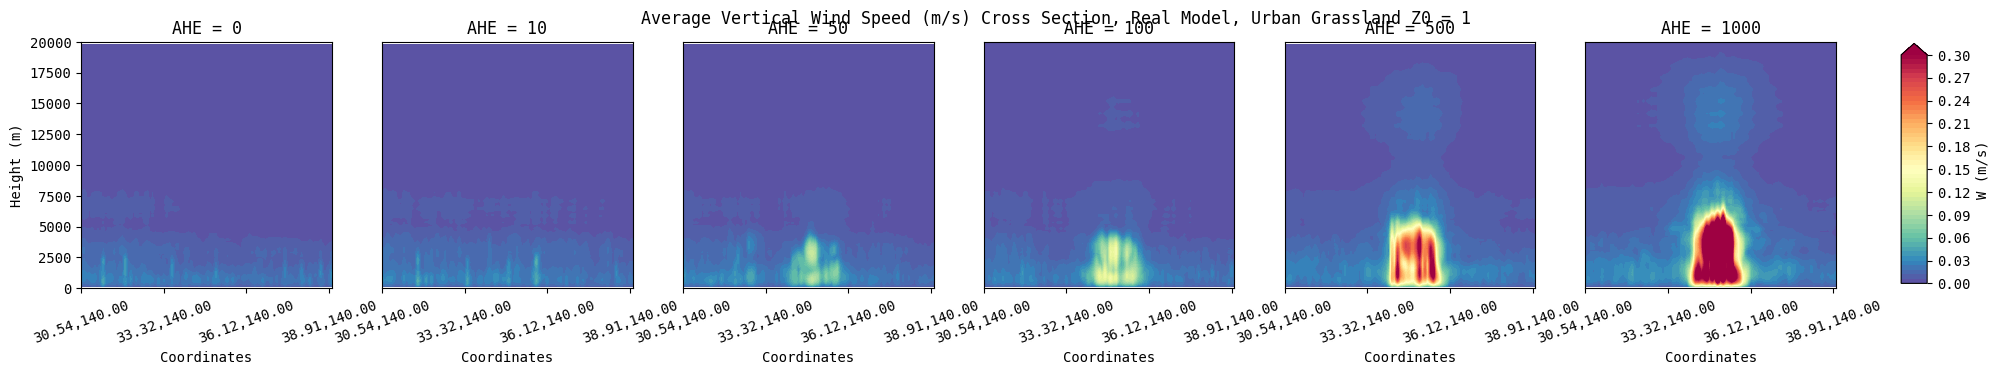

In [22]:
plt.rcParams["font.family"] = "DejaVu Sans Mono"

column_counts = 6

fig, axes = plt.subplots(1, column_counts, figsize=(26, 3.2))
plot_lim = np.linspace(0, 0.3, 51)

for idx, z0 in enumerate(AHE_VALUES):
    i, j = idx // column_counts, idx % column_counts

    var = results[z0]

    # coord_pairs = to_np(template_varcross.coords['xy_loc']) # Did some quick hack here
    coord_pairs = to_np(var_cross.coords['xy_loc']) # Did some quick hack here
    coord_pair_labels = [pair.latlon_str(fmt='{:.2f},{:.2f}') for pair in to_np(coord_pairs)]

    if j == 0:
        axes[j].set_ylabel('Height (m)')
    else:
        axes[j].set_yticks([])
    if i == 0:
        axes[j].set_xlabel('Coordinates')
        axes[j].set_xticks(np.arange(coord_pairs.shape[0])[::30])
        axes[j].set_xticklabels(coord_pair_labels[::30], rotation=20)
    else:
        axes[j].set_xticks([])

    contour = axes[j].contourf(coord_pair_labels, vert_levels, var / len(times), plot_lim, cmap="Spectral_r", extend='max')
    axes[j].set_title(f'AHE = {z0}')

    if i == 0 and j == 3:
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes((0.825, 0.125, 0.01, 0.75))
        cbar = fig.colorbar(contour, cax=cbar_ax, ticks=plot_lim[::5])
        cbar.ax.set_ylabel('W (m/s)')

fig.suptitle(f"Average Vertical Wind Speed (m/s) Cross Section, Real Model, Urban Grassland Z0 = 1")

# plt.savefig('/home/guc/results/w-contour-z0-ahe-100.png')
plt.savefig('/home/guc/results/w-contour-ahe-z0-1.png')